In [1]:
import warnings
warnings.simplefilter('ignore')
import sys
import cmlreaders as cml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
plt.style.use('seaborn')
plt.rcParams['savefig.facecolor']='white'
import seaborn as sns
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None
import pandas_to_pybeh as pp
import scipy as scp
from scipy.spatial import distance
from polar import circular_hist
from adjustText import adjust_text

# Courier Report

In [2]:
data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'DBOY1']
print("Size of Dataset:")
print(len(data), 'sessions')
print(len(data['subject'].unique()), 'subjects')
data[['subject', 'session', 'experiment']]
subs_list=data['subject']

Size of Dataset:
89 sessions
43 subjects


In [3]:
def get_dboy_data(sub):
    data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] =='DBOY1']

    data = data[data['subject']==sub]

    full_evs = None
    for i, row in data.iterrows():
        read = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'])
        evs = read.load('task_events')
        full_evs = evs if full_evs is None else full_evs.append(evs)
    # only real delivery days
    full_evs = full_evs.reset_index().drop(columns='index')
    return full_evs

In [4]:
# Test EEG (assumes bipolar)
pairs = read.load('pairs')
pres = evs[evs.type=='WORD']
eeg = read.load_eeg(pres, scheme=pairs, rel_start=-500, rel_stop=500).to_ptsa()
plt.plot(eeg.time, eeg.values[pres.recalled.astype(bool)].mean((0, 1))-eeg.values[~pres.recalled.astype(bool)].mean((0, 1)))

NameError: name 'read' is not defined

In [4]:
# check if cued-recall was correct
def cued_recall_sucess(full_evs):
    correct_total=[]
    incorrect_total=[]
    list_correct=[]
    list_incorrect=[]
    for sess in full_evs['session'].unique()[full_evs['session'].unique()>=0]:
        DD_sess=full_evs[full_evs['session']==sess]
        for DD in DD_sess['trial'].unique()[DD_sess['trial'].unique()>=0]:
            bool_array=[]
            DD_list=DD_sess[DD_sess['trial']==DD]
            index_start=DD_list[DD_list['type']=='REC_STOP'].index
            if len(index_start)>0:
                DD_cued=DD_list.loc[index_start[0]+1:]
                assert len(DD_cued[DD_cued['type']=='CUED_REC_CUE'])==12
                cued_Recall_index=DD_cued[DD_cued['type']=='CUED_REC_CUE'].index
                if len(cued_Recall_index)>0:
                    for row in cued_Recall_index:
                        bool_array.append(DD_list.loc[row]['item']==DD_list.loc[row+1]['item'])
                    assert len(bool_array)==12
                    list_correct=sum(bool_array)
                    list_incorrect=12-sum(bool_array)
                    
                correct_total.append(list_correct)
                incorrect_total.append(list_incorrect)
#     if len(incorrect_total)==[[]]:
#         incorrect_total=12
#     if len(correct_total)==[[]]:
#         correct_total=0

    return sum(correct_total),sum(incorrect_total)


In [5]:
subject_behavioral=pd.DataFrame([])
FFR_times=pd.DataFrame([])
for sub in subs_list.unique():
    full_evs=get_dboy_data(sub)
    pres = full_evs[full_evs.type=='WORD']
    recall = full_evs[full_evs.type=='REC_WORD']

    cuerec = full_evs[full_evs.type=='CUED_REC_WORD']
    cue = full_evs[full_evs.type=='CUED_REC_CUE']
    final = full_evs[full_evs.type=='FFR_REC_WORD']
    storerec = full_evs[full_evs.type=='SR_REC_WORD']

    cued_recalls = [full_evs.loc[i, "item"]==full_evs.loc[i+1, "item"] for i in cue.index.values]
    cued_correct = sum(cued_recalls)
    cued_incorrect = len(cued_recalls)-sum(cued_recalls)

    number_correct=len(recall[recall['intrusion']==0])
    number_ELIs=len(recall[recall['intrusion']==-1])
    number_PLIs=len(recall[recall['intrusion']>0])

#     cued_correct,cued_incorrect=cued_recall_sucess(full_evs)
    correct_ffr=len(final[final['intrusion']==0])
    ELI_ffr=len(final[final['intrusion']==-1])
    PLI_ffr=len(final[final['intrusion']>0])

    correct_stores=len(storerec[storerec['intrusion']==0])
    ELI_stores=len(storerec[storerec['intrusion']==-1])
    PLI_stores=len(storerec[storerec['intrusion']>0])

    
    number_sessions=len(full_evs['session'].unique()[full_evs['session'].unique()>=0])
    number_DD=[]
    for sess in full_evs['session'].unique()[full_evs['session'].unique()>=0]:
        session_data=full_evs[full_evs['session']==sess]
        end_index=session_data[session_data['type']=='SR_START'].index-2
        if len(end_index)==0:
            end_index=[len(session_data)]
        number_DD.append(len(session_data[:end_index[0]]['trial'].unique()[session_data[:end_index[0]]['trial'].unique()>=0]))
    number_DDs=sum(number_DD)
    
    subject_behavioral=subject_behavioral.append({'subject':sub,'number_sessions':number_sessions,'number_DDs':number_DDs,'number_FRcorrect':number_correct,
                                                                'number_FR_ELIs':number_ELIs,
                                                                'number_FR_PLIs': number_PLIs,
                                                                'number of cued correct': cued_correct,
                                                               'number of cued incorrect': cued_incorrect,
                                                               'number of correct final FR': correct_ffr,
                                                               'number of ELI final FR':ELI_ffr,
                                                               'number of PLI final FR':PLI_ffr,
                                                               'number of correct stores': correct_stores,
                                                                'number of ELI stores': ELI_stores,
                                                                'number of PLI stores': PLI_stores,
                                                               },ignore_index=True)
    FFR_times = FFR_times.append({'subject':sub,'rectime':final['rectime'],'number_sessions':number_sessions,'number_DDs':number_DDs},ignore_index=True)






subject_behavioral

,number of ELI final FR,number of ELI stores,number of PLI final FR,number of PLI stores,number of correct final FR,number of correct stores,number of cued correct,number of cued incorrect,number_DDs,number_FR_ELIs,number_FR_PLIs,number_FRcorrect,number_sessions,subject
0,1.0,13.0,0.0,0.0,16.0,6.0,37.0,143.0,17.0,0.0,2.0,31.0,3.0,R1494D
1,6.0,16.0,0.0,0.0,56.0,19.0,35.0,37.0,6.0,0.0,2.0,43.0,1.0,R1501J
2,4.0,19.0,0.0,0.0,23.0,10.0,38.0,118.0,14.0,3.0,6.0,56.0,2.0,R1502D
3,24.0,29.0,0.0,0.0,56.0,16.0,64.0,104.0,16.0,12.0,2.0,91.0,3.0,R1503E
4,3.0,10.0,0.0,0.0,31.0,3.0,36.0,12.0,4.0,0.0,0.0,19.0,1.0,R1504E
5,7.0,34.0,0.0,0.0,88.0,29.0,140.0,40.0,18.0,1.0,1.0,110.0,6.0,R1509E
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,4.0,0.0,0.0,1.0,R1513D
7,2.0,3.0,0.0,0.0,6.0,2.0,5.0,7.0,1.0,0.0,0.0,3.0,1.0,R1520T
8,1.0,29.0,0.0,0.0,44.0,21.0,46.0,74.0,12.0,2.0,0.0,51.0,3.0,R1521E
9,24.0,15.0,0.0,0.0,2.0,8.0,14.0,94.0,10.0,23.0,1.0,22.0,2.0,R1523E


number of subjects: 40


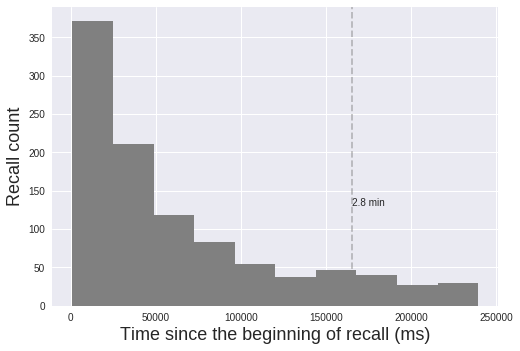

In [72]:
rectimes=[]
for sub in range(0,len(list(FFR_times['rectime']))):
    rectimes.extend(FFR_times['rectime'][sub])
     

plt.hist(rectimes,bins=10,color='grey')
plt.xlabel('Time since the beginning of recall (ms)',fontsize=18)
plt.ylabel('Recall count',fontsize=18)
plt.axvline(x=np.percentile(rectimes,90),color='grey',linestyle='--',alpha=0.5)
x=np.percentile(rectimes,90)
plt.text(x,130,'%.1f min' %(x/1000/60))

print('number of subjects:', len(FFR_times['subject'].unique()))

Text(0, 0.5, 'Recall count')

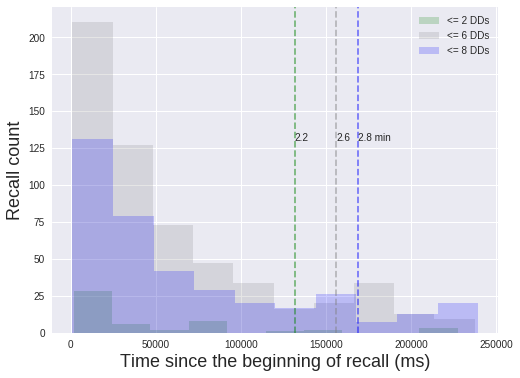

In [8]:
rectimes_DD2=[]
rectimes_DD4=[]
rectimes_DD6=[]
rectimes_DD8=[]
for sub in range(0,len(list(FFR_times['rectime']))):
    if FFR_times['number_DDs'][sub]/FFR_times['number_sessions'][sub] <=2:
        rectimes_DD2.extend(FFR_times['rectime'][sub])
    elif FFR_times['number_DDs'][sub]/FFR_times['number_sessions'][sub] <=4:
        rectimes_DD4.extend(FFR_times['rectime'][sub])
#     elif FFR_times['number_DDs'][sub]/FFR_times['number_sessions'][sub] <=6:
#         rectimes_DD6.extend(FFR_times['rectime'][sub])
    elif FFR_times['number_DDs'][sub]/FFR_times['number_sessions'][sub] <=8:
        rectimes_DD8.extend(FFR_times['rectime'][sub])

plt.figure(figsize=(8,6))
plt.hist(rectimes_DD2,bins=10,alpha=0.2,label='<= 2 DDs',color='green')
plt.axvline(x=np.percentile(rectimes_DD2,90),color='green',linestyle='--',alpha=0.5)
x=np.percentile(rectimes_DD2,90)
plt.text(x,130,'%.1f' %(x/1000/60))

plt.hist(rectimes_DD4,bins=10,alpha=0.2,label='<= 6 DDs',color='gray')
plt.axvline(x=np.percentile(rectimes_DD4,90),color='gray',linestyle='--',alpha=0.5)
x=np.percentile(rectimes_DD4,90)
plt.text(x,130,'%.1f' %(x/1000/60))

# plt.hist(rectimes_DD6,bins=10,alpha=0.2,label='DD6')
plt.hist(rectimes_DD8,bins=10,alpha=0.2,label='<= 8 DDs',color='blue')
plt.axvline(x=np.percentile(rectimes_DD8,90),color='blue',linestyle='--',alpha=0.5)
x=np.percentile(rectimes_DD8,90)
plt.text(x,130,'%.1f min' %(x/1000/60))

plt.legend(loc='upper right')
plt.xlabel('Time since the beginning of recall (ms)',fontsize=18)
plt.ylabel('Recall count',fontsize=18)

In [7]:
def delivery_durations(full_evs):
    durations=[]
    for session_n in full_evs['session'].unique():
        session_data=full_evs[full_evs['session']==session_n]
        for trial_n in session_data['trial'].unique()[session_data['trial'].unique()>=0]:
            trial_data=session_data[session_data['trial']==trial_n]
            words_index=list(trial_data[trial_data.type=='WORD'].index)
            if len(words_index)==12: # 12 words per list
            #   words_index.append(words_index[0]-1)
                words_data=trial_data.loc[np.sort(words_index)]
                for i in range(0,len(words_data)-1):
                    durations.append(words_data['mstime'].iloc[i+1] - words_data['mstime'].iloc[i])
    return durations

1.5 std of the mean are: 74.0
number of subject: 2783


Text(47.67699999999999, 200, ' 80 percentile: 47.7 sec')

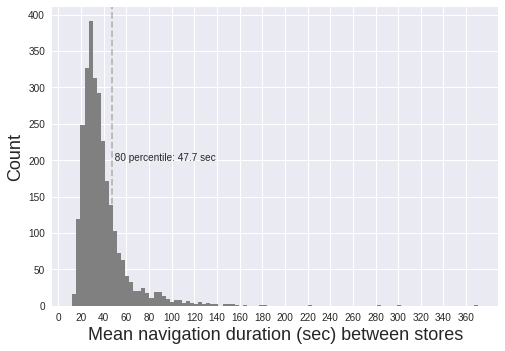

In [12]:
subs_delivery_durations=[]
for sub in subs_list.unique():
    full_evs=get_dboy_data(sub)
    durations=delivery_durations(full_evs)
#     mean_duration=np.mean(durations)
    mean_duration_sec=np.array(durations)/1000
    subs_delivery_durations.extend(mean_duration_sec)

mean_duration=np.mean(subs_delivery_durations)
std_duration=np.std(subs_delivery_durations)
cutoff=np.ceil(mean_duration+1.5*std_duration)
print('1.5 std of the mean are:', cutoff)
print('number of subject:', len(subs_delivery_durations))

# plot
plt.hist(subs_delivery_durations,bins=100,color='grey')
plt.xlabel('Mean navigation duration (sec) between stores',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.xticks(np.arange(0, max(subs_delivery_durations), step=20))


# plt.axvline(x=cutoff,color='green',linestyle='--',alpha=0.5)
# plt.text(cutoff,250,'Z = 1.5, %1.f sec' %(cutoff))

# plt.axvline(x=mean_duration,color='green',linestyle='--',alpha=0.5)
# plt.text(mean_duration,300,'M = %1.f sec' %(mean_duration))
# plt.axvline(x=np.median(subs_delivery_durations),color='green',linestyle='--',alpha=0.5)
# plt.text(np.median(subs_delivery_durations),350,'Median = %1.f sec' %(np.median(subs_delivery_durations)))

plt.axvline(x=np.percentile(subs_delivery_durations,80),color='grey',linestyle='--',alpha=0.5)
x=np.percentile(subs_delivery_durations,80)
plt.text(x,200,' 80 percentile: %.1f sec' %(x))

number of participants 40
number of sessions 85.0


Text(2.5, 7, '$M_{sessions}$ = 2.1')

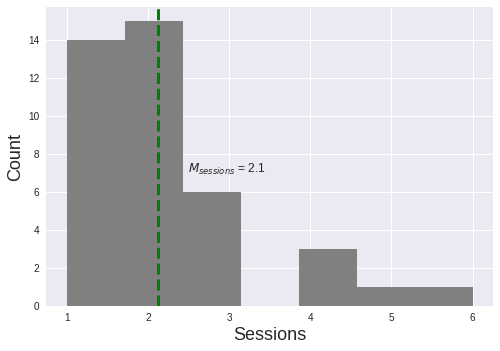

In [113]:
print('number of participants',len(subject_behavioral['subject'].unique()))
print('number of sessions',sum(subject_behavioral['number_sessions']))


plt.hist(subject_behavioral['number_sessions'],bins=7, color='grey')
mean_sessions=np.mean(subject_behavioral['number_sessions'])
plt.axvline(x=mean_sessions,color='green',linestyle='--',linewidth=3)
# plt.xlim(xmin=-0.35, xmax=0.35)
plt.xlabel('Sessions',fontsize=18)
plt.ylabel('Count',fontsize=18)
# plt.axvline(x=0,color='gray',linestyle='--',linewidth=1)
# plt.hist(pearson_p,bins=20, color=None)
plt.text(2.5,7,'$M_{sessions}$ = %.1f' %mean_sessions,fontsize=12)

Text(13, 5.5, '$M$ = 14.4')

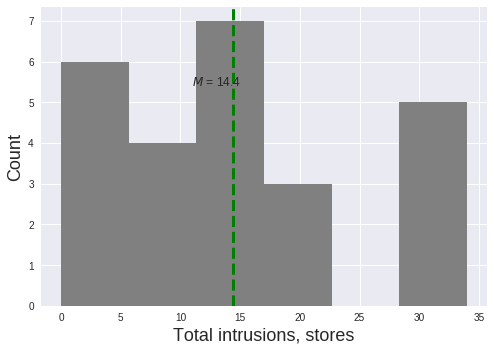

In [751]:
var= 'number of ELI stores' #'number_FRcorrect'
var_name= 'Total intrusions, stores' #'Sum correct in FR'
plt.hist(subject_behavioral[var],bins=6, color='grey')
mean_DDs=np.mean(subject_behavioral[var])
plt.axvline(x=mean_DDs,color='green',linestyle='--',linewidth=3)
# plt.xlim(xmin=-0.35, xmax=0.35)
plt.xlabel(var_name,fontsize=18)
plt.ylabel('Count',fontsize=18)
# plt.axvline(x=0,color='gray',linestyle='--',linewidth=1)
# plt.hist(pearson_p,bins=20, color=None)
plt.text(13,5.5,'$M$ = %.1f' %mean_DDs,fontsize=12,horizontalalignment='center',verticalalignment='center')#,transform=ax.transAxes)

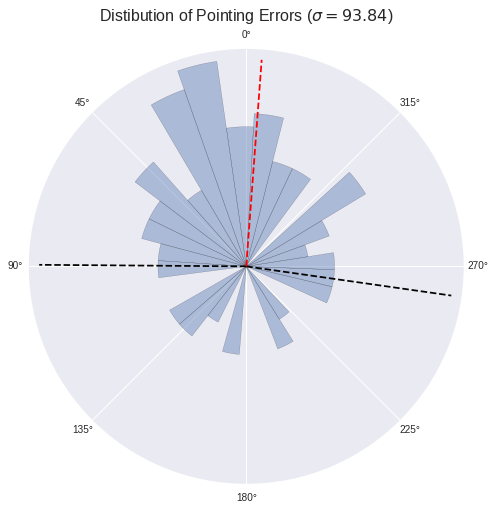

In [7]:
pointing_tasks = full_evs[full_evs.type == 'pointing finished']
# err_angles = np.radians((pointing_tasks.correctPointingDirection - pointing_tasks.submittedPointingDirection)).values
err_angles = np.radians((pointing_tasks.submittedPointingDirection - pointing_tasks.correctPointingDirection)).values
err_angles = (err_angles+np.pi) % (2*np.pi) - np.pi

# correct for distribution of available stores
loc_evs = full_evs[(full_evs.storeX!=-999)&(full_evs.store!='-999')]
stores = loc_evs.groupby('store').agg('mean')[['storeX', 'storeZ']]
xstores = stores['storeX'].values; zstores = stores['storeX'].values
angular_range = []
for i, row in pointing_tasks.iterrows():
    # current player location
    xloc, zloc = row[['presX', 'presZ']]
    # distribution of angles from location to all stores
    angles = np.arctan((zloc-zstores)/(xloc-xstores))
    angles[xloc-xstores<0]+= np.pi
    angular_range.append(np.ptp(angles))
angular_range = np.array(angular_range)
# multiply errors by ratio of whole field to available angular distribution of stores
err_angles = err_angles * (2*np.pi)/ angular_range

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
n, bins, _ = circular_hist(ax, err_angles, offset=np.pi/2, bins=30, ec='k', alpha=0.4)
ax.vlines([np.mean(err_angles)+err_angles.std(), np.mean(err_angles)-err_angles.std()], ymin=0, ymax=np.max(n/err_angles.size/np.pi)**.5,
         ls='--')
ax.vlines(np.mean(err_angles),
          ymin=0, ymax=np.max(n/err_angles.size/np.pi)**.5,
         ls='--', colors='r')

ax.set_title(r'Distibution of Pointing Errors ($\sigma = {:.2f}$)'.format(err_angles.std()*180/np.pi), fontsize=16)
plt.show()

Median Delivery Time: 19.04 seconds
RMSE: 11.913, R^2: 0.178


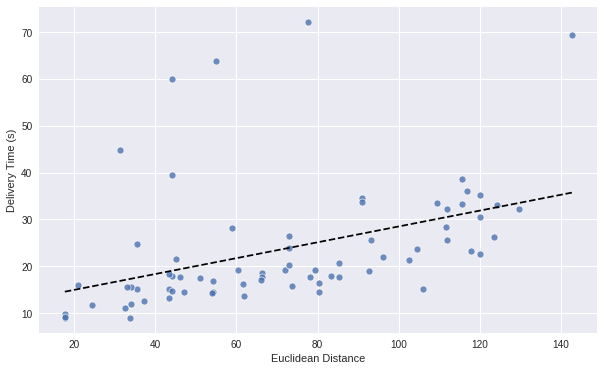

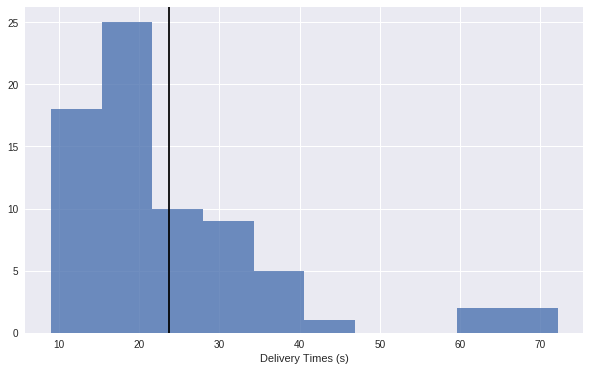

In [9]:
deliveries = full_evs[full_evs.type=='WORD']
diff_times = np.insert(np.diff(full_evs.mstime), 0, 0)
delivery_times = diff_times[full_evs.type == 'WORD']
print('Median Delivery Time: {:.2f} seconds'.format(np.median(delivery_times)/1000))

distX = np.insert(np.diff(deliveries.storeX), 0, deliveries.iloc[0].storeX)
distZ = np.insert(np.diff(deliveries.storeZ), 0, deliveries.iloc[0].storeZ)
dist = np.sqrt(distX**2 + distZ**2)

plt.figure(figsize=(10, 6))
p, resid, _, _, _= np.polyfit(dist, delivery_times/1000, 1, full=True)
sns.scatterplot(dist, delivery_times/1000, alpha=.8)
plt.xlabel('Euclidean Distance')
plt.ylabel('Delivery Time (s)')
vals = np.arange(np.min(dist), np.max(dist))
plt.plot(vals, np.polyval(p, vals), 'k--')
rmse = np.sqrt(np.mean((np.polyval(p, dist) - delivery_times/1000)**2))
r2 = np.corrcoef(dist, delivery_times/1000)[0, 1]**2
print(r'RMSE: {:.3f}, R^2: {:.3f}'.format(rmse, r2))

plt.figure(figsize=(10, 6))
plt.xlabel('Delivery Times (s)')
plt.hist(delivery_times/1000, alpha=.8)
_ = plt.axvline(delivery_times.mean()/1000, 0, max(delivery_times/1000), c='k')

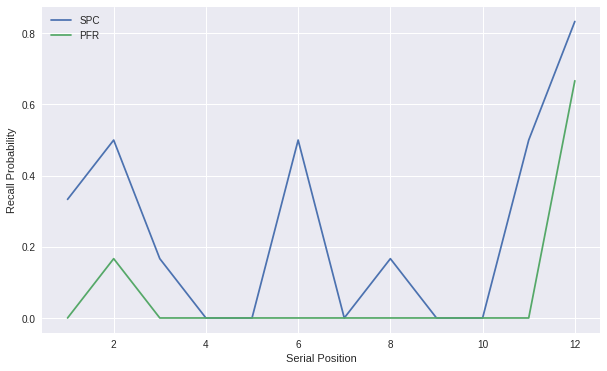

In [10]:
deliveries = full_evs[full_evs.type=='WORD']
deliveries['pos'] = deliveries.groupby(['subject', 'session', 'trial']).cumcount()
delivRecalls = deliveries.pivot_table(values = ['recalled'], index=['subject', 'session', 'trial'], columns='pos')

recword = full_evs[full_evs.type=='REC_WORD']
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
recallpos = recword.pivot_table(values = ['serialpos'], index=['subject', 'session', 'trial'], columns='pos')

plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 13), delivRecalls['recalled'].mean(), label = 'SPC')
plt.xlabel('Serial Position')
plt.ylabel('Recall Probability')

listLength = 12
pfr = np.zeros(listLength)
for pos in recallpos['serialpos'].iloc[:, 0]:
    if pos>0:
        pfr[int(pos)-1]+=1
    else:
        continue
pfr = pfr/len(recallpos)

plt.plot(np.arange(1, listLength + 1), pfr, label = 'PFR')
plt.legend()
plt.show()

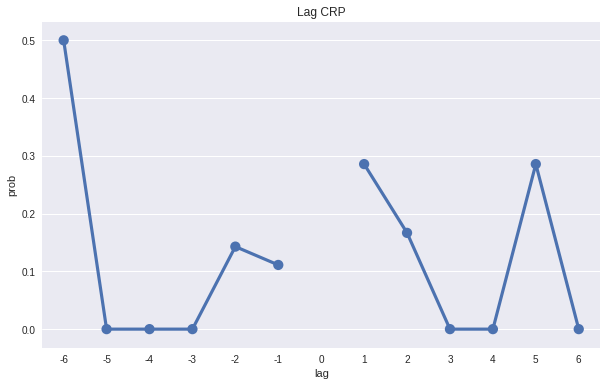

In [11]:
import pandas_to_pybeh as pb

# filter out lists with no recalls
# for i in full_evs.session.unique():
#     for j in full_evs.trial.unique():
#         word = full_evs[(full_evs.session==i)&(full_evs.trial==j)&(full_evs.type=='REC_WORD')]
#         if (len(word)==0)&(j>0):
#             full_evs.drop(full_evs[(full_evs.session==i)&(full_evs.trial==j)].index, inplace=True)

full_evs['itemno'] = full_evs['item'].astype('category').cat.codes
crp_df = full_evs.groupby(['subject']).apply(pb.pd_crp, itemno_column='itemno', 
                               list_index=['subject', 'session', 'trial'], 
                               lag_num=6).reset_index()
plt.figure(figsize=(10, 6))
crp = sns.pointplot(data=crp_df, x='lag', y='prob')
_ = crp.set_title('Lag CRP')

Session 0


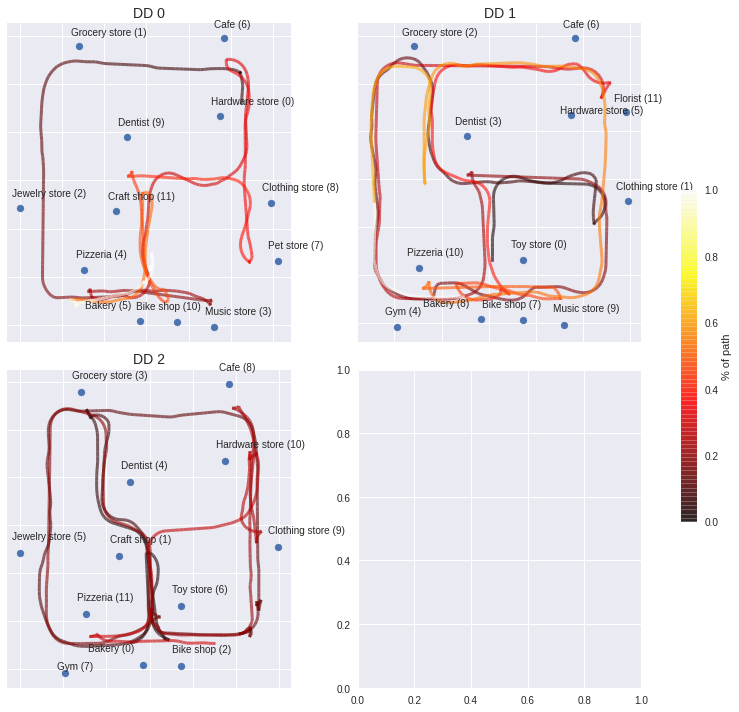

Session 1


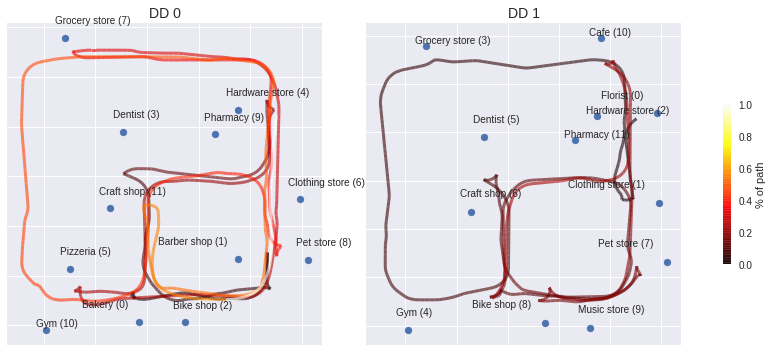

Session 2


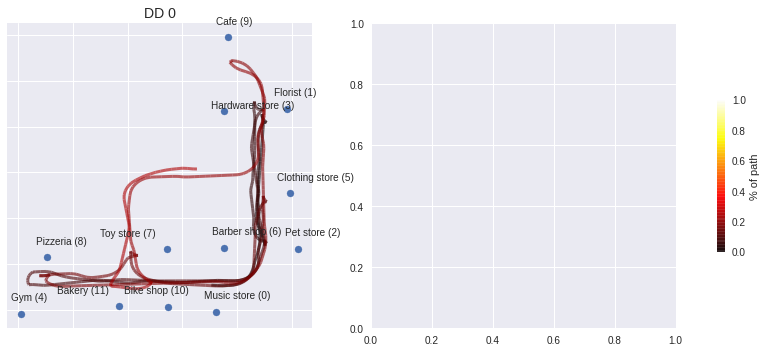

In [82]:
for session in data['session'].unique():
    print('Session %d' %session)
    log = pd.read_json('/data/eeg/{}/behavioral/DBOY1/session_{}/session.jsonl'.format(sub, session), lines=True)
    log = log[(log.type=='PlayerTransform')|(log.type=='object presentation begins')]

    def extract_position(row):
        if row.type=='PlayerTransform':
            return (row['data']['positionX'], row['data']['positionY'], row['data']['positionZ'])
        elif row.type=='object presentation begins':
            return eval(row['data']['player position'])
        else:
            return np.nan

    log['location']=log.apply(extract_position, axis=1)
    log['trial']=log.apply(lambda row: row['data']['trial number'] if np.isin('trial number', list(row['data'].keys())) else np.nan, axis=1)
    movements = log.fillna(method='pad').dropna()
    sess_pos = np.stack(list(map(list, movements.location.values)))
    
    group_mov = movements.groupby('trial')
    dd_list = np.array(list(group_mov.groups.keys())).astype(int)
    pos_by_list = [np.stack(list(map(list, group_mov.get_group(i)['location']))) for i in dd_list]
    fig, ax = plt.subplots(len(dd_list)//2+len(dd_list)%2, 2, figsize=(12, 5*(len(dd_list)//2+len(dd_list)%2)))
    ax = ax.ravel()
    for i, dd in enumerate(dd_list):
        store_locs = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: eval(json['store position']))
        store_names = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: json['store name'])
        list_stores = np.stack(list(map(list, store_locs.values)))

        points = np.array([pos_by_list[i][:, 0], pos_by_list[i][:, 2]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='hot')
        # Set the values used for colormapping
        lc.set_array(np.linspace(0, 1, len(segments)))
        lc.set_linewidth(3); lc.set_alpha(.6)
        line = ax[i].add_collection(lc)
        ax[i].scatter(list_stores[:, 0], list_stores[:, 2])
        texts = []
        for x, y, name, order in zip(list_stores[:, 0], list_stores[:, 2], store_names, np.arange(len(store_names))):
            texts.append(ax[i].text(x-5, y+5, name.capitalize() + ' ({})'.format(order)))
        adjust_text(texts)
        ax[i].set_title('DD %d' %dd, fontsize=14)
        ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
    plt.tight_layout()
    cbar = fig.colorbar(line, ax=ax[:], location='right', shrink = 0.5)
    cbar.set_label('% of path')
    fig.set_facecolor('white')
    plt.show()